In [6]:
import pandas as pd
import time

import json
import httplib2
import sys
import codecs
       
import re

import numpy as np
import math
import ast

import warnings
warnings.filterwarnings("ignore")

import json

import geog
import shapely.geometry
from shapely.geometry import Point

In [8]:
df = pd.read_csv('new_venues_clean.csv', encoding = "ISO-8859-1")

df.drop(['in_the_box'],axis =1, inplace=True)

Origin Lat/Long 34.05223 -118.24368
Destination Lat/Long 37.77493 -122.41942
Radius 80


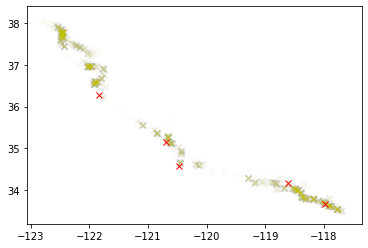

In [40]:
### Input
####### LA to SF (around 1204 POI)
x_0 = 34.05223
y_0 = -118.24368
x_f = 37.77493
y_f = -122.41942

####### San Jose to SD (around 1320 POI)
#x_0 = 37.3382082
#y_0 = -121.8863286
#x_f = 32.715738
#y_f = -117.1610838

# Oakland to SD  (around 1299 POI)
#x_0 = 37.8044
#y_0 = -122.2712
#x_f = 32.715738
#y_f = -117.1610838

# San Jose to SF (around 653 POI)
#x_0 = 37.3382082
#y_0 = -121.8863286
#x_f = 37.77493
#y_f = -122.41942

# Palo Alto to LA (around 872 POI)
#x_0 = 37.4419
#y_0 = -122.1430
#x_f = 34.05223
#y_f = -118.24368

# Oakland to SF  (around 1299 POI)
#x_0 = 37.8044
#y_0 = -122.2712
#x_f = 37.77493
#y_f = -122.41942

print ("Origin Lat/Long", x_0, y_0)
print ("Destination Lat/Long", x_f, y_f)
#approximate distance between points (aka "radius")
radius = 80 # approximately 50 miles
print ("Radius", radius)

#these points will simulate the poi geo filter tracking to a chosen coastal route
split_list = [(34.577185, -120.477600),(36.26943, -121.8392222),(34.16249,-118.6064028),(35.1477777,-120.6945983),(33.6635854,-117.9820209)]
split_list = sorted(split_list, key=lambda x: x[0])

#visualize split points relevative to poi data set
ax = plt.subplot(1, 1, 1)
ax.plot(df.lng, df.lat, "xy", alpha= .01)
ax.plot([p[1] for p in split_list], [p[0] for p in split_list], "xr")

In [38]:
def poi_inside_box_optimize(x_0, y_0, x_f, y_f,df,radius):
        #print('radius= ', radius)
        # Haversine distance from origin to Destination
        dlat = math.radians(x_f - x_0)
        dlon = math.radians(y_f - y_0)
        haversine_radius = 6371  # km
        a = math.sin(dlat / 2) * math.sin(dlat / 2) + math.cos(math.radians(x_f)) \
            * math.cos(math.radians(x_0)) * math.sin(dlon / 2) * math.sin(dlon / 2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        haversine_dist = haversine_radius * c
        
        no_of_points = round(haversine_dist / radius) - 1

        x_delta = (x_f - x_0) / max(1,no_of_points) #to protect agains dividing by zero
        y_delta = (y_f - y_0) / max(1,no_of_points)
        list_of_centroids = [(x_0 + i * x_delta, y_0 + i * y_delta) for i in range(0, max(1,no_of_points))]
        list_of_centroids.append((x_f, y_f))
        
    
        for (x, y) in list_of_centroids:
            df.loc[(abs(df["lat"]-x)<abs(x_delta)) & (abs(df["lng"]-y)<abs(y_delta)), 'in_the_box'] = True
            
        #print(df[df['in_the_box'] == True].shape[0])    
        return df

def poi_with_split(x_0, y_0, x_f, y_f, df, radius, split_list): #recursive
       #remove split points if they are lower than the x_0 or higher than x_f
    split_list = [(x[0],x[1]) for x in split_list if x[0]>x_0 and x[0]<x_f]
    
    #end if no split points between origin and dest
    if len(split_list)==0:
        return(poi_inside_box_optimize(x_0,y_0,x_f,y_f,df,radius=radius))
    #otherwise split the data frame and split list 
    elif (x_0 <split_list[0][0]< x_f or x_f <split_list[0][0]< x_0):
        mask = df['lat']<=split_list[0][0]
        df1 = poi_with_split(x_0, y_0, split_list[0][0], split_list[0][1], df[mask], radius, split_list = [])
        df2 = poi_with_split(split_list[0][0], split_list[0][1], x_f,y_f, df[~mask], radius, split_list = split_list)
        df_result = pd.concat([df1,df2])
        return(df_result)

def poi_with_safe_split(x_0, y_0, x_f, y_f, df, radius, split_list):
    #initialize column
    df['in_the_box'] = False
    
    #arrange origin and destination by x val
    if(x_0>x_f):
        print('arrange origin and destination by x val')
        x_temp, y_temp = x_0,y_0
        x_0,y_0 = x_f,y_f
        x_f,y_f = x_temp, y_temp
        print(x_0,y_0)
        print(x_f,y_f)
        
    #filter out things that are above and below are start points, this is a temporary measure
    df_result = poi_with_split(x_0, y_0, x_f,y_f, df, radius = radius, split_list = split_list)
    df_result.loc[((df_result["lat"]<x_0) | (df_result["lat"]>x_f)), 'in_the_box'] = False
    return(df_result)

In [50]:
##%%timeit
start = time.time()
df_result_r_10 = poi_with_safe_split(x_0, y_0, x_f,y_f, df, radius = 10, split_list = split_list)
time_10 = time.time() - start

start = time.time()
df_result_r_20 = poi_with_safe_split(x_0, y_0, x_f,y_f, df, radius = 20, split_list = split_list)
time_20 = time.time() - start

start = time.time()
df_result_r_40 = poi_with_safe_split(x_0, y_0, x_f,y_f, df, radius = 40, split_list = split_list)
time_40 = time.time() - start

start = time.time()
df_result_r_80 = poi_with_safe_split(x_0, y_0, x_f,y_f, df, radius = 80, split_list = split_list)
time_80 = time.time() - start

pd.DataFrame({'radius':[10,20,40,80], 'time':[time_10,time_20,time_40,time_80], 'in_box_true':[sum(df_result_r_10.in_the_box),sum(df_result_r_20.in_the_box),sum(df_result_r_40.in_the_box),sum(df_result_r_80.in_the_box)]})

,radius,time,in_box_true
0,10,5.264,592
1,20,1.886,1656
2,40,0.799,2258
3,80,0.488,2362


In [51]:
%%timeit
poi_with_safe_split(x_0, y_0, x_f,y_f, df, radius = 10, split_list = split_list)

4.21 s ± 733 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


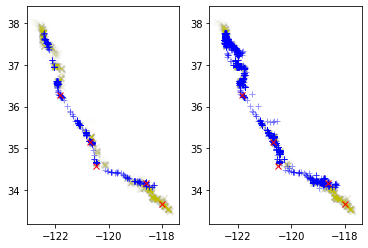

In [61]:
#Visualize Results
df_splits = pd.DataFrame(split_list, columns=['lat', 'lng'])
df_start_end = pd.DataFrame([(x_0, y_0),( x_f,y_f)], columns=['lat', 'lng'])

ax = plt.subplot(1, 2, 1)
df_inside_the_box = df_result_r_10[df_result_r_10['in_the_box'] == True] 


ax.plot(df.lng, df.lat, "xy", alpha= .01)
ax.plot(df_inside_the_box.lng, df_inside_the_box.lat, '+b', alpha=0.4)
ax.plot(df_splits.lng, df_splits.lat, "xr")


ax2 = plt.subplot(1, 2, 2)
df_inside_the_box = df_result_r_80[df_result_r_80['in_the_box'] == True] 


ax2.plot(df.lng, df.lat, "xy", alpha= .01)
ax2.plot(df_inside_the_box.lng, df_inside_the_box.lat, '+b', alpha=0.4)
ax2.plot(df_splits.lng, df_splits.lat, "xr")

plt.show()